In [1]:
# Introduction to Clustering
#We are taking a particular subset of genre aof movie and trying to visualise if there ar eany clusters amongs it
#we are considering the romance and comedy subset

import pandas as pd
import json
import numpy as np
import seaborn as sns


In [2]:
#imporitng the data set
df = pd.read_csv('movies_metadata.csv')
print(df.head())
print(len(df))

   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497         

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#converting the JSON format of Genres to a list
from ast import literal_eval
columns=['genres']
def  get_value(x):
    l = []
    if isinstance(x,list):
        for i in x:
               l.append(i['name'])
        return ' '.join(l)
    return []


for column in columns:
    df[column] = df[column].apply(literal_eval)
    df[column] = df[column].apply(get_value)



In [4]:
from sklearn.cluster import KMeans

#using the foollowing features for KMeans
use_columns = ['id','original_title','genres']

use_columns_1 = ['userId','movieId','rating']

df1 = df

df1 = pd.DataFrame(df,columns = use_columns)

#converting non numeric types to numeric types

df1['id'] = df1['id'].apply(pd.to_numeric, errors='coerce')

# Extracting only those movies which contains Romance and Comedy

df1_romance = df1[df1['genres'].str.contains('Romance')]

df1_comedy = df1[df1['genres'].str.contains('Comedy')]

#since we are using features from 2 different sub datasets,we are loading the 2nd data set

df2 = pd.read_csv('ratings.csv')

df2 = pd.DataFrame(df2,columns = use_columns_1)

#converting to Numeric type

df2['userId'] = df2['userId'].apply(pd.to_numeric,errors = 'coerce')

df2['movieId'] = df2['movieId'].apply(pd.to_numeric,errors = 'coerce')

df2['rating'] = df2['rating'].apply(pd.to_numeric,errors = 'coerce')

#merging the movies which contains the genre as romance

df3 = pd.merge(df1_romance,df2,left_on = 'id',right_on = 'movieId',how = 'inner')

#merging the movies which conatins the genre as Comedy

df3_1 = pd.merge(df1_comedy,df2,left_on = 'id',right_on = 'movieId',how = 'inner')

#extracting the average mean rating of a particular user for its respective genres

df3 = df3.groupby(['userId'])['rating'].mean()

df3_1 = df3_1.groupby(['userId'])['rating'].mean()

df4 = pd.merge(df3,df3_1,on='userId',how = 'inner')

#renaming the columns

df4 = df4.rename(columns = {'rating_x':'Avg_Romance_ratings','rating_y':'Avg_Comedy_ratings'})

print(df4.head())



        Avg_Romance_ratings  Avg_Comedy_ratings
userId                                         
1                  3.333333                4.25
2                  4.000000                2.80
3                  3.333333                3.20
4                  3.166667                3.00
5                  5.000000                5.00


        Avg_Romance_ratings  Avg_Comedy_ratings
userId                                         
59                 1.833333            3.166667
66                 3.500000            1.500000
522                0.500000            3.500000
745                1.500000            3.200000
1004               1.000000            5.000000


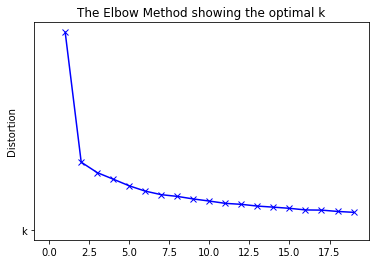

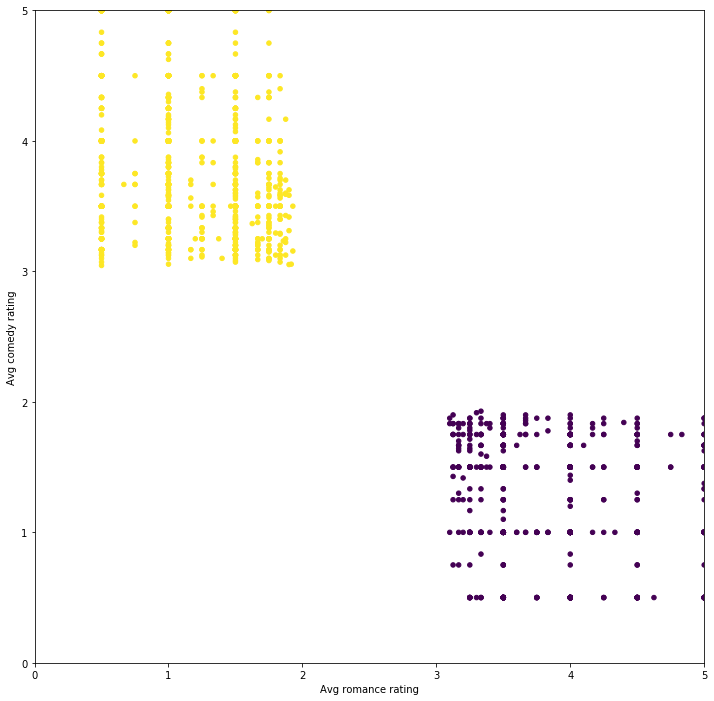

In [5]:

#print(df4['Avg_Romance_ratings'].value_counts())

#print(df4['Avg_Comedy_ratings'].value_counts())

#starting K means Clustering algorithm
from sklearn.cluster import KMeans

from matplotlib.pyplot import *

from scipy.spatial.distance import cdist

#trying to form a cluster of people who like romance movies or comedy movies by setting a threshold

df4 = df4[((df4['Avg_Romance_ratings'] < 2.0) & (df4['Avg_Comedy_ratings'] > 3.0)) | ((df4['Avg_Comedy_ratings'] < 2.0) & (df4['Avg_Romance_ratings'] > 3.0))]

data_set = df4[['Avg_Romance_ratings','Avg_Comedy_ratings']].values

print(df4.head())

distortions = []

#using the Elbow method to find the optimal K- value
K = range(1,20)

for k in K:
    
    kmeanModel = KMeans(n_clusters=k).fit(data_set)
    
    kmeanModel.fit(data_set)
    
    distortions.append(sum(np.min(cdist(data_set, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / data_set.shape[0])

# Plot the elbow curve to determine the optimal value of K
matplotlib.pyplot.plot(K, distortions, 'bx-')

matplotlib.pyplot.plot('k')

matplotlib.pyplot.ylabel('Distortion')

matplotlib.pyplot.title('The Elbow Method showing the optimal k')

matplotlib.pyplot.show()

kmeans = KMeans(n_clusters = 2)

pred = kmeans.fit_predict(data_set)


#plotting of the cluster

fig = matplotlib.pyplot.figure(figsize=(12,12))

axis =  fig.add_subplot(111)

matplotlib.pyplot.xlim(0, 5)

matplotlib.pyplot.ylim(0, 5)

axis.set_xlabel('Avg romance rating')

axis.set_ylabel('Avg comedy rating')

clustered = pd.concat([df4.reset_index(), pd.DataFrame({'group':pred})], axis=1)

matplotlib.pyplot.scatter(df4['Avg_Romance_ratings'], df4['Avg_Comedy_ratings'], c=clustered['group'], s=20)


#Please note that we have tried to implement K means to form clusters. This can be further imporved by forming a recommendation system 
#and we tried to do the reccomendation system but couldnot obtain much success so we thought of just stoppping it at this point.

